In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [3]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/Dataset_final.csv'


In [4]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[2,3], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [5]:
train_df.head(10)

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,Neutral
1,baru mengirim foto,Neutral
2,apa kabar dunia twitter masihkah selucu seabsu...,Neutral
3,yah gimana sih yaudah susul sebelumnya sarapan...,Neutral
4,ka dorg suro beli medium set,Neutral
5,ayo cek koleksinya temukan angry draken unik n...,Neutral
6,kalau biasa biasa sudah,Neutral
7,tiap tiap twit tak selalu perlu pesan moral ka...,Neutral
8,halo v apa kabar nih,Neutral
9,pagi ruby apa kabar,Neutral


In [6]:
train_df.head(10)

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,Neutral
1,baru mengirim foto,Neutral
2,apa kabar dunia twitter masihkah selucu seabsu...,Neutral
3,yah gimana sih yaudah susul sebelumnya sarapan...,Neutral
4,ka dorg suro beli medium set,Neutral
5,ayo cek koleksinya temukan angry draken unik n...,Neutral
6,kalau biasa biasa sudah,Neutral
7,tiap tiap twit tak selalu perlu pesan moral ka...,Neutral
8,halo v apa kabar nih,Neutral
9,pagi ruby apa kabar,Neutral


In [7]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    if label == 'Sad':
        return 4
    if label == 'Love':
        return 3
    if label == 'Joy':
        return 2
    if label == 'Anger':
        return 1
    if label == 'Neutral':
        return 0


train_df['emotion'] = train_df['emotion'].apply(get_label_idx)

In [8]:
train_df

,full_text,emotion
0,pengabdian terpuji meskipun terlihat biasa,0
1,baru mengirim foto,0
2,apa kabar dunia twitter masihkah selucu seabsu...,0
3,yah gimana sih yaudah susul sebelumnya sarapan...,0
4,ka dorg suro beli medium set,0
...,...,...
57028,cod beli euphoria wonderland la foret fairy ha...,2
57029,ลองด cod flash sale ก โล แมคคายกกระสอบ ต กก ต ...,2
57030,wal cod an shopee kawa pakai qris lah yuu,0
57031,temukan bisa cod light stick treasure bluetoot...,0


In [9]:
#hapus label selain 0-5
train_df = train_df[train_df['emotion'] <= 5]

# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

In [10]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

Jumlah Netral:  12984
Jumlah Marah:  11069
Jumlah Senang:  12312
Jumlah Cinta:  5396
Jumlah Sedih:  7275
Jumlah Takut:  7997


In [11]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [12]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")


Shape of X_train: (57033,)
Shape of y_train: (57033,)


In [13]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((51329,), (5704,), (51329,), (5704,))

## Generate Padded Sequence

In [15]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




In [17]:
print(train_padded[0])

[  431  4178  1664  1131  1562  6959    49    66  3666  7311  7683 14774
  1213  1088   887   159   261    73    25  6329    65    19  1935   703
   502  6034     6    39   629   281     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


## Word Embedding

In [18]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [19]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-2.97048306, -1.20485878, -0.5607152 , ..., -1.64795649,
         0.73396289,  3.14575601],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [21]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

('pulang', array([-2.59919691, -1.83267081,  2.61292291,  1.51026297,  6.54161024,
       -0.64422035, -0.44674829, -2.54546309]))


## Build and Compile Model

In [22]:
# convert to bi-lstm model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8,  embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

c:\Users\TEMP\miniconda3\envs\skripsi\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 8)          │       480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        37,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 519,542 (1.98 MB)

 Trainable params: 39,542 (154.46 KB)

 Non-trainable params: 480,000 (1.83 MB)

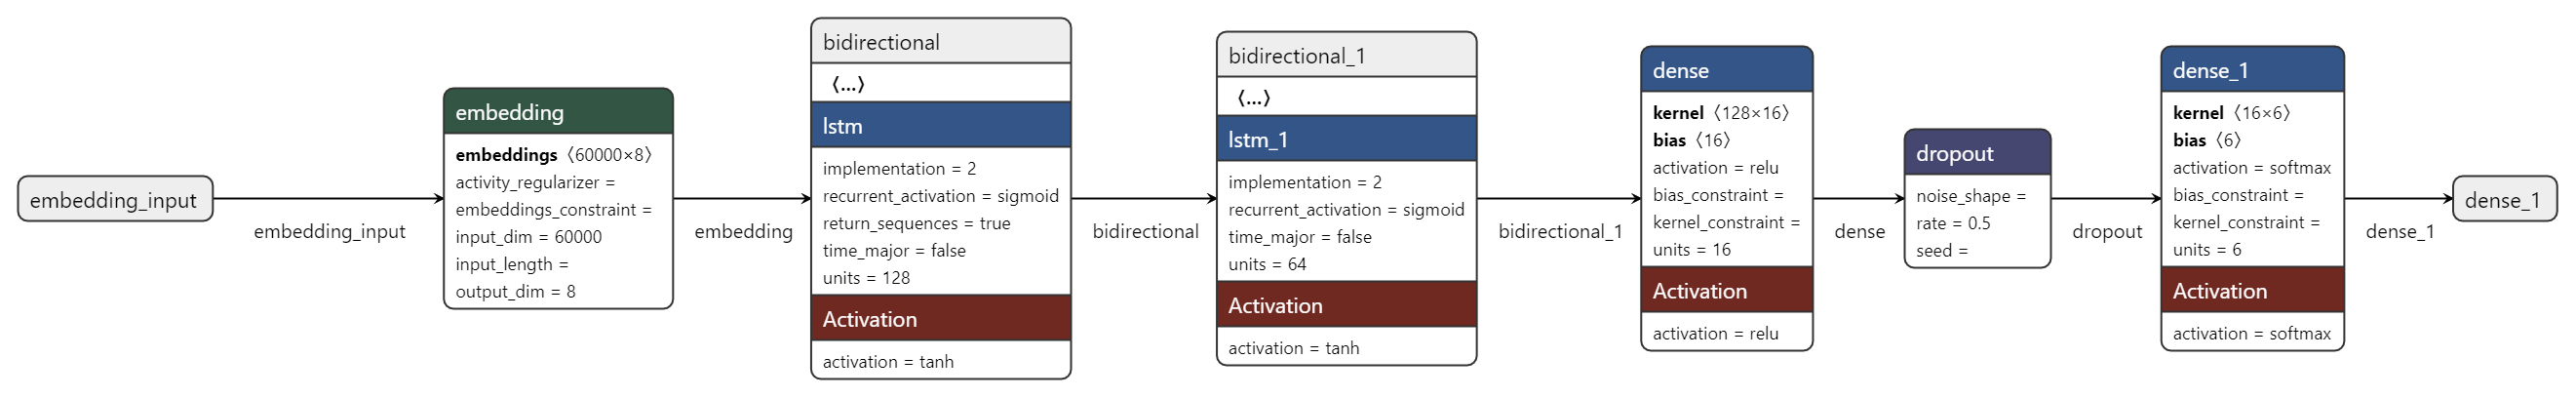

In [23]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding
Weights Shape (Tensor 0): (60000, 8)
Weights (Tensor 0):
[[ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [-2.970483  -1.2048588 -0.5607152 ... -1.6479565  0.7339629  3.145756 ]
 ...
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
Layer Name: bidirectional
Weights Shape (Tensor 0): (8, 256)
Weights (Tensor 0):
[[-0.11341292 -0.08905251 -0.06877904 ...  0.02708466  0.00948647
  -0.05750689]
 [ 0.09117301  0.04185618 -0.12371568 ... -0.08135292  0.0377281
  -0.0065781 ]
 [-0.00973289 -0.01284173 -0.07582195 ... -0.08621202  0.04048561
   0.14174911]
 ...
 [-0.14251058 -0.05310176  0.10224339 ... -0.13383129  0.03629379
   0.09866633]
 [ 0.04980902  0.08730802  0.05923687 ...  0.11812577  0.13588527
  

## Train Model

In [24]:
num_epochs = 150

history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
)

Epoch 1/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.3292 - loss: 1.6278 - val_accuracy: 0.4360 - val_loss: 1.4340
Epoch 2/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4040 - loss: 1.4863 - val_accuracy: 0.4413 - val_loss: 1.4080
Epoch 3/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.4259 - loss: 1.4482 - val_accuracy: 0.4749 - val_loss: 1.3608
Epoch 4/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.4374 - loss: 1.4227 - val_accuracy: 0.4760 - val_loss: 1.3511
Epoch 5/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.4469 - loss: 1.4071 - val_accuracy: 0.4921 - val_loss: 1.3332
Epoch 6/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - accuracy: 0.4581 - loss: 1.3818 - val_accuracy: 0.5009 - val_loss: 1.3225
Epoch 7/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4690 - loss: 1.3728 - val_accuracy: 0.5060 - val_loss: 1.3047
Epoch 8/150
402/402 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.4756 - loss: 1

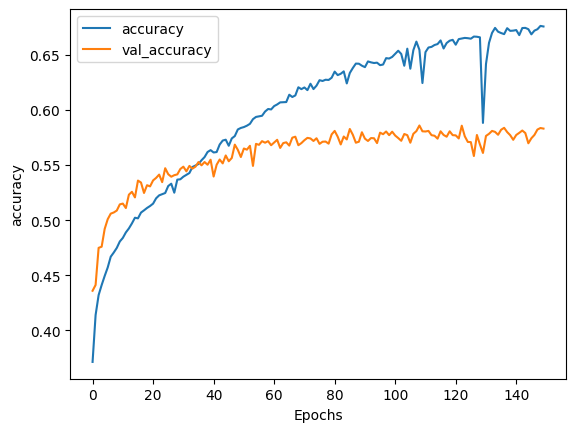

In [25]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

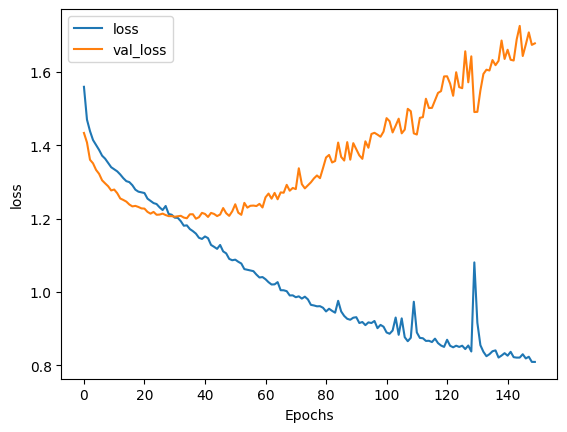

In [26]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [27]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

179/179 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5749 - loss: 1.7105
Loss:  1.678467869758606
Accuracy:  0.5830996036529541
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
              precision    recall  f1-score   support

           0       0.60      0.46      0.52      1321
           1       0.48      0.73      0.58      1070
           2       0.65      0.70      0.67      1211
           3       0.66      0.47      0.55       536
           4       0.64      0.58      0.60       728
           5       0.59      0.50      0.54       838

    accuracy                           0.58      5704
   macro avg       0.60      0.57      0.58      5704
weighted avg       0.60      0.58      0.58      5704



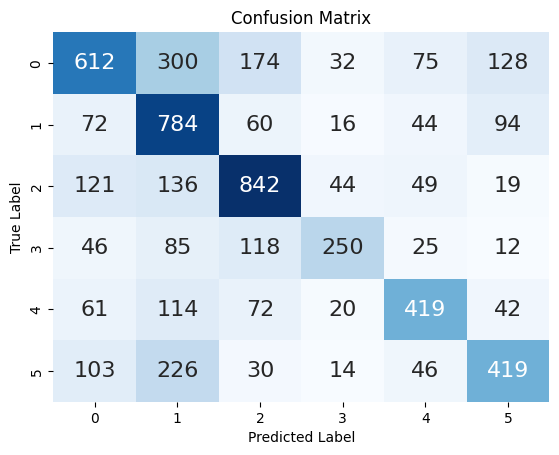

In [28]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [29]:
print(cm)

[[612 300 174  32  75 128]
 [ 72 784  60  16  44  94]
 [121 136 842  44  49  19]
 [ 46  85 118 250  25  12]
 [ 61 114  72  20 419  42]
 [103 226  30  14  46 419]]


In [39]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#buatkan 10 kalimat untuk di prediksi dalam bahasa indonesia kalimat random
kalimat = [
    "kenapa fans persib goblok semua iya",
    "Aku sangat sedih melihat berita ini",
    "Aku sangat takut melihat hantu",
    "Aku sangat marah dengan perlakuanmu",
    "Aku sangat cinta dengan kamu",
    "Aku sangat senang bisa bertemu denganmu",
    "Aku sangat sedih karena kamu pergi",
    "Aku sangat takut dengan keadaan ini",
    "Aku sangat marah dengan kejadian ini",
    "Aku sangat cinta dengan keluargaku"
]

# Prediksi emosi dari semua kalimat
for text in kalimat:
    print("Kalimat:", text)
    print("Emosi:", predict_emotion(text))
    print()

Kalimat: kenapa fans persib goblok semua iya
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediksi: [[0.20005767 0.36767906 0.13663083 0.05365422 0.09841739 0.14356084]]
Emosi: Anger

Kalimat: Aku sangat sedih melihat berita ini
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi: [[0.14223896 0.2209428  0.23791628 0.03356801 0.2729793  0.09235458]]
Emosi: Sad

Kalimat: Aku sangat takut melihat hantu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediksi: [[1.6411676e-01 2.5709931e-02 7.9687889e-05 9.3083190e-06 1.7121589e-02
  7.9296267e-01]]
Emosi: Fear

Kalimat: Aku sangat marah dengan perlakuanmu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediksi: [[0.1781077  0.45993707 0.09132962 0.0468313  0.10188793 0.12190643]]
Emosi: Anger

Kalimat: Aku sangat cinta dengan kamu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediksi: [[3.2398042e-03 1.1911946e-14 1.8295123e-03 9.9493057e-01 1.0580060e-07
  5.6029183e-13]]
Emosi: Love

Kalimat: Aku sangat senang bisa bertemu denganmu
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Pred

In [31]:
#save model
model.save('./model/model-bilstm.h5')

In [32]:
import pickle

with open('tokenizer-emotion.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
